In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0014428.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0013644.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0013736.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0014809.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0015243.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0015256.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0014985.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0012434.jpg
/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid/melanoma/ISIC_0014302.jpg
/kaggle/input/skin-lesion-analysis-toward-mela

# 1. Importing the necessary libraries


In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load the data

In [3]:
DATA_DIR = "/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [4]:
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32 
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_dataset = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

class_names = list(train_dataset.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Detected Classes:", class_names)

Found 2000 images belonging to 3 classes.
Detected Classes: ['melanoma', 'nevus', 'seborrheic_keratosis']


In [5]:
def plot_class_distribution(dataset, title):
    class_counts = np.sum(dataset.labels, axis=0)
    plt.bar(class_names, class_counts, color='skyblue')
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()


Class Distribution BEFORE Augmentation:


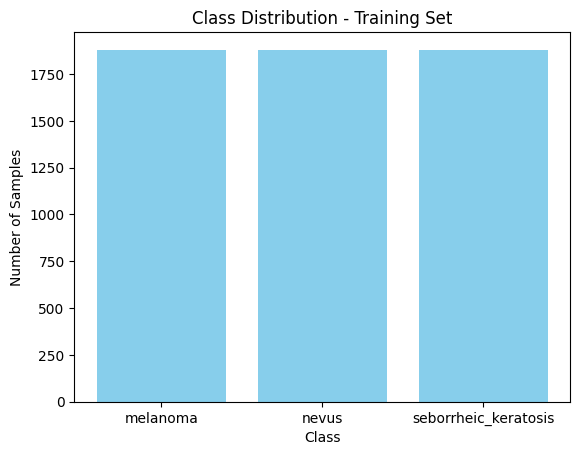

In [6]:
print("Class Distribution BEFORE Augmentation:")
plot_class_distribution(train_dataset, "Training Set")

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,  # Increased
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Added
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_dataset = train_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_dataset = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get actual class names
class_names = list(train_dataset.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Detected Classes:", class_names)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Detected Classes: ['melanoma', 'nevus', 'seborrheic_keratosis']


# 3. Visualize the balanced data

Training Set Class Distribution:


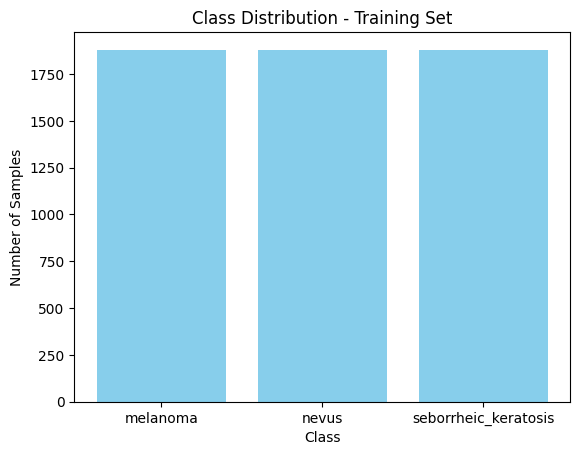

Validation Set Class Distribution:


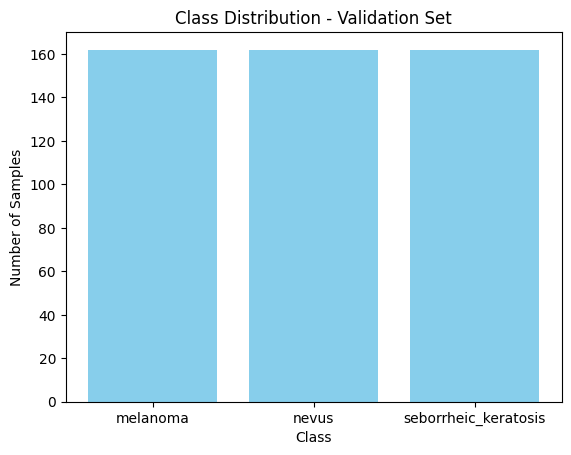

Test Set Class Distribution:


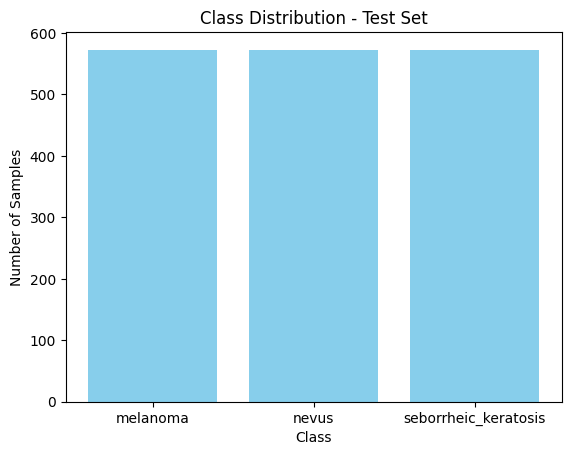

In [8]:
def plot_class_distribution(dataset, title):
    class_counts = np.sum(dataset.labels, axis=0)
    plt.bar(class_names, class_counts, color='skyblue')
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

print("Training Set Class Distribution:")
plot_class_distribution(train_dataset, "Training Set")

print("Validation Set Class Distribution:")
plot_class_distribution(valid_dataset, "Validation Set")

print("Test Set Class Distribution:")
plot_class_distribution(test_dataset, "Test Set")

In [10]:
train_augmentation = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset_augmented = train_augmentation.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 2000 images belonging to 3 classes.


In [11]:
def build_custom_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),  # Helps in better feature extraction
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')  # Ensure NUM_CLASSES is set correctly
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
from sklearn.utils.class_weight import compute_class_weight
custom_model = build_custom_model()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
history_custom = custom_model.fit(
    train_dataset_augmented,
    validation_data=valid_dataset,
    epochs=30,
    class_weight=class_weight_dict
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.3621 - loss: 1.2342 - val_accuracy: 0.5200 - val_loss: 1.0658
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.4633 - loss: 1.0782 - val_accuracy: 0.5200 - val_loss: 1.0340
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.4519 - loss: 1.0654 - val_accuracy: 0.5200 - val_loss: 1.0568
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.4718 - loss: 0.9999 - val_accuracy: 0.5200 - val_loss: 1.0789
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.4532 - loss: 1.0245 - val_accuracy: 0.5267 - val_loss: 1.0385
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.4706 - loss: 0.9993 - val_accuracy: 0.5200 - val_loss: 1.0507
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.4937 - loss: 0.9220 - val_accuracy: 0.5000 - val_loss: 0.9941
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5212 - loss: 0.9260 - val_accuracy: 0.5200 - val_loss: 1.

In [37]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
y_pred = custom_model.predict(valid_dataset)
y_pred = y_pred.argmax(axis=1)  # Convert softmax outputs to class labels
y_true = valid_dataset.classes  # Assuming `valid_dataset` has class labels
custom_accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {custom_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step
Validation Accuracy: 0.5400


In [38]:
print(f"Custom CNN Model Accuracy : {custom_accuracy*100:.2f}%")

Custom CNN Model Accuracy : 54.00%


19/19 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step


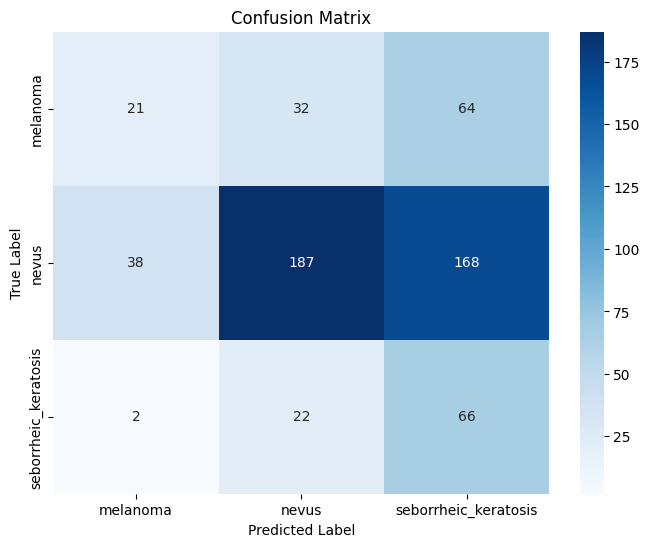

Classification Report:
                      precision    recall  f1-score   support

            melanoma       0.34      0.18      0.24       117
               nevus       0.78      0.48      0.59       393
seborrheic_keratosis       0.22      0.73      0.34        90

            accuracy                           0.46       600
           macro avg       0.45      0.46      0.39       600
        weighted avg       0.61      0.46      0.48       600



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


true_labels = test_dataset.classes  # Actual class indices

# Get predictions
predictions = custom_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax output to class indices

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


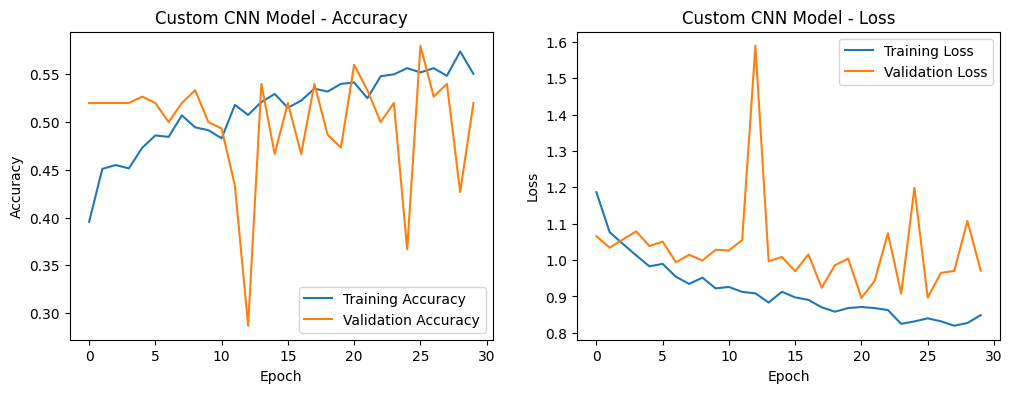

In [40]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_custom, "Custom CNN Model")  # Use `history_custom`


In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Build Transfer Learning Model with Partial Unfreezing
def build_transfer_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze last few layers for fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize Model
transfer_model = build_transfer_model()
transfer_model.summary()

# Compute Class Weights for Imbalanced Data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)
class_weight_dict = dict(enumerate(class_weights))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 111, 111, 32)   │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 109, 109, 32)   │             96 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 109, 109, 64)   │            192 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 54, 54, 80)     │            240 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 52, 52, 192)    │            576 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,912,227 (91.22 MB)

 Trainable params: 23,873,699 (91.07 MB)

 Non-trainable params: 38,528 (150.50 KB)

In [18]:
history_transfer = transfer_model.fit(
    train_dataset_augmented,
    validation_data=valid_dataset,
    epochs=30,  
    class_weight=class_weight_dict 
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.4195 - loss: 1.5575 - val_accuracy: 0.5200 - val_loss: 1.3874
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.5307 - loss: 1.0928 - val_accuracy: 0.5133 - val_loss: 1.0899
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.5843 - loss: 0.9432 - val_accuracy: 0.5333 - val_loss: 1.1330
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6397 - loss: 0.7882 - val_accuracy: 0.5733 - val_loss: 0.9768
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.6269 - loss: 0.7860 - val_accuracy: 0.5667 - val_loss: 1.0162
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.6820 - loss: 0.6849 - val_accuracy: 0.6800 - val_loss: 0.7638
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.6726 - loss: 0.6487 - val_accuracy: 0.5467 - val_loss: 1.1163
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7051 - loss: 0.5547 - val_accuracy: 0.6200 - v

In [19]:
test_loss, test_accuracy = transfer_model.evaluate(test_dataset)
print(f"Test Accuracy Of Inception V3 : {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 126s 7s/step - accuracy: 0.5890 - loss: 1.9564
Test Accuracy Of Inception V3 : 71.33%


In [20]:
y_pred_prob = transfer_model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)  
y_true = test_dataset.classes

accuracy = accuracy_score(y_true, y_pred)
print(f"Inception V3 Model Accuracy: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step
Inception V3 Model Accuracy: 71.33%


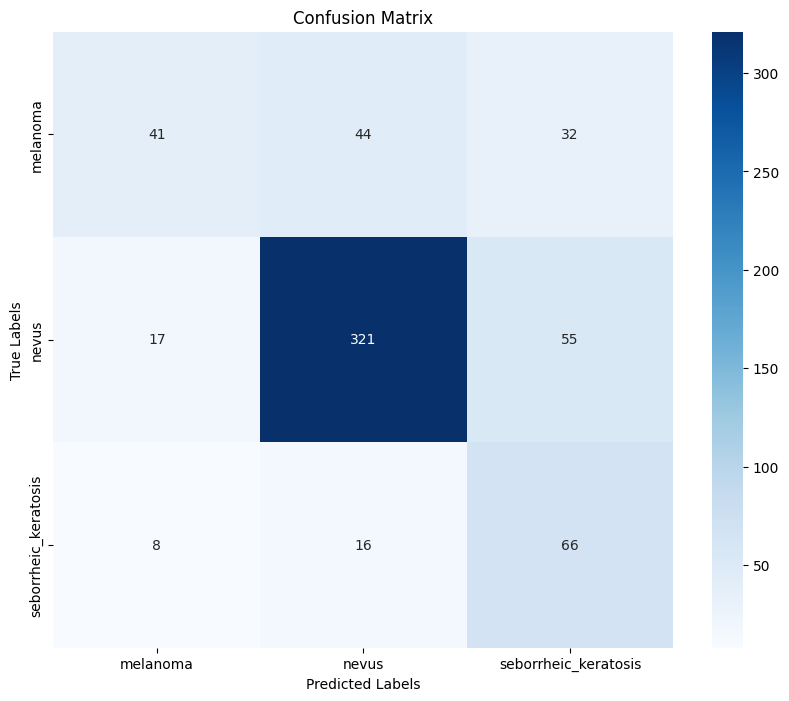

Classification Report:
                       precision    recall  f1-score   support

            melanoma       0.62      0.35      0.45       117
               nevus       0.84      0.82      0.83       393
seborrheic_keratosis       0.43      0.73      0.54        90

            accuracy                           0.71       600
           macro avg       0.63      0.63      0.61       600
        weighted avg       0.74      0.71      0.71       600



In [21]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


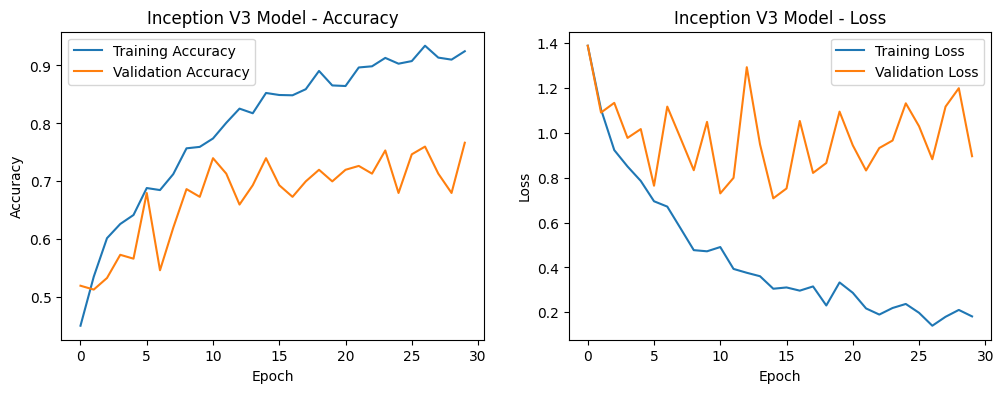

In [22]:
plot_history(history_transfer, "Inception V3 Model")

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Build Transfer Learning Model with Partial Unfreezing
def build_resnet50v2_model():
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze last few layers for fine-tuning
    for layer in base_model.layers[-20:]:  
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize ResNet50V2 Model
resnet50v2_model = build_resnet50v2_model()
resnet50v2_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 25,674,243 (97.94 MB)

 Trainable params: 25,624,707 (97.75 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [26]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)
class_weight_dict = dict(enumerate(class_weights))

history_resnet50v2 = resnet50v2_model.fit(
    train_dataset_augmented,
    validation_data=valid_dataset,
    epochs=30,
    class_weight=class_weight_dict
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.3374 - loss: 1.3905 - val_accuracy: 0.5200 - val_loss: 1.0910
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.5283 - loss: 1.0157 - val_accuracy: 0.5400 - val_loss: 0.9790
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5801 - loss: 0.9305 - val_accuracy: 0.5867 - val_loss: 0.9250
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6098 - loss: 0.9397 - val_accuracy: 0.6200 - val_loss: 0.9330
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6303 - loss: 0.7637 - val_accuracy: 0.5800 - val_loss: 0.9379
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.6668 - loss: 0.6776 - val_accuracy: 0.6200 - val_loss: 0.8271
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.6878 - loss: 0.6257 - val_accuracy: 0.6600 - val_loss: 0.8717
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.7084 - loss: 0.6089 - val_accuracy: 0.7133 - v

In [27]:
y_pred_prob = resnet50v2_model.predict(test_dataset)  
y_pred = np.argmax(y_pred_prob, axis=1)  
y_true = test_dataset.classes  

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"ResNet50V2 Model Accuracy: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 121s 6s/step
ResNet50V2 Model Accuracy: 75.17%


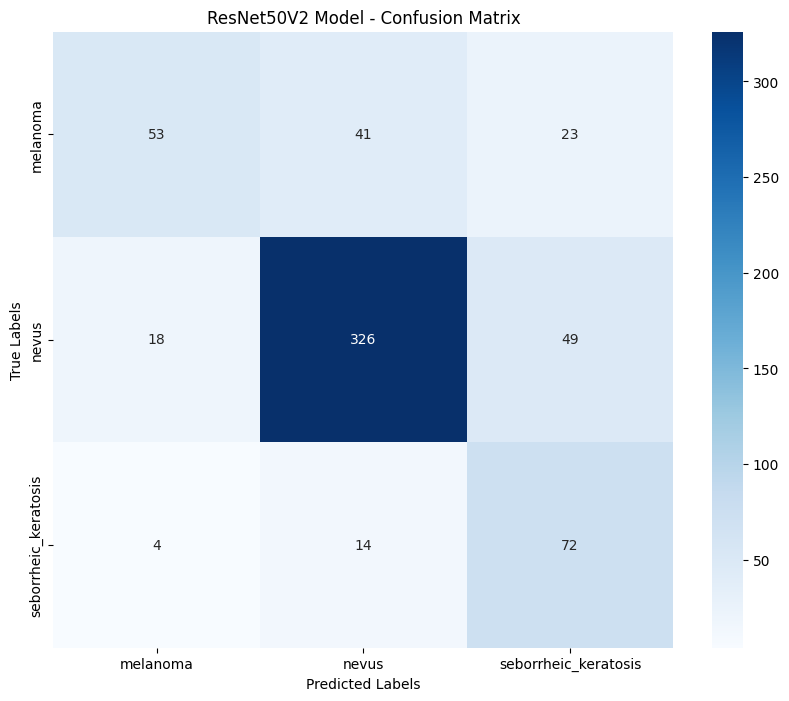

Classification Report:
                       precision    recall  f1-score   support

            melanoma       0.71      0.45      0.55       117
               nevus       0.86      0.83      0.84       393
seborrheic_keratosis       0.50      0.80      0.62        90

            accuracy                           0.75       600
           macro avg       0.69      0.69      0.67       600
        weighted avg       0.77      0.75      0.75       600



In [28]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("ResNet50V2 Model - Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


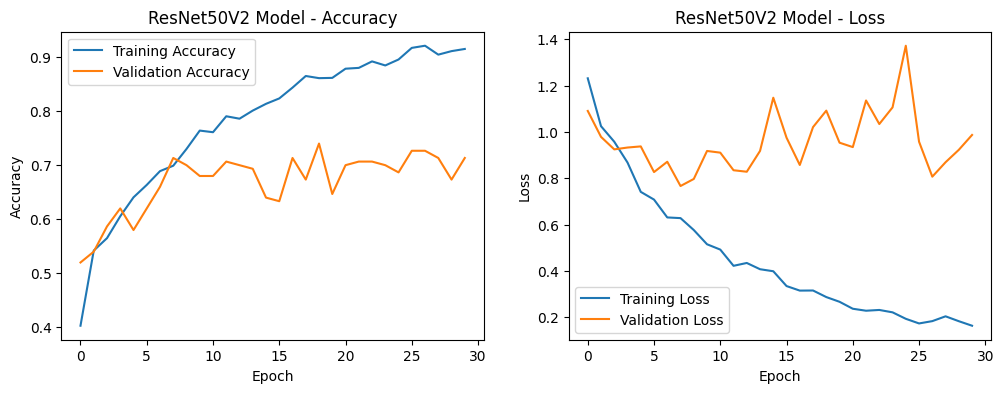

In [29]:
plot_history(history_resnet50v2, "ResNet50V2 Model")

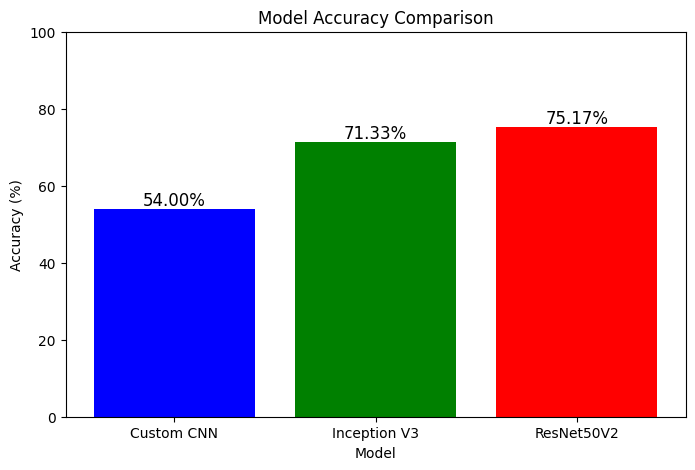

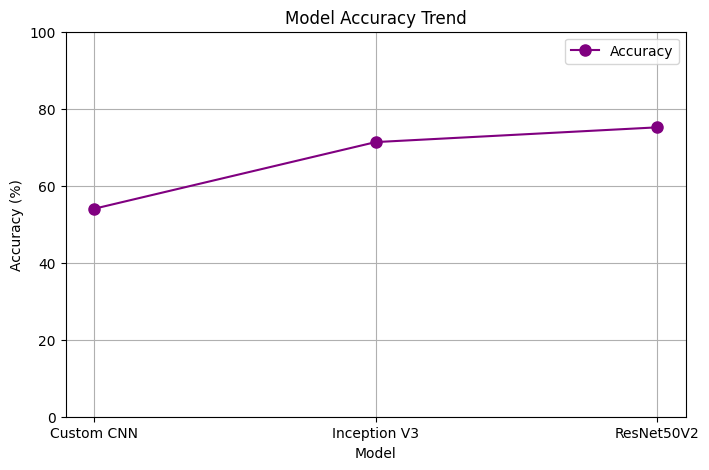

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Rename accuracy variables to avoid confusion
accuracy_custom_cnn = custom_accuracy * 100  # From Custom CNN Model
accuracy_inception_v3 = test_accuracy * 100  # From Inception V3 Model
accuracy_resnet50v2 = accuracy * 100  # From ResNet50V2 Model

# Store accuracy values from each model
model_names = ["Custom CNN", "Inception V3", "ResNet50V2"]
accuracies = [accuracy_custom_cnn, accuracy_inception_v3, accuracy_resnet50v2]

# Bar Chart for Model Comparison
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)
plt.show()

# Line Graph for Model Performance Comparison
plt.figure(figsize=(8, 5))
plt.plot(model_names, accuracies, marker='o', linestyle='-', color='purple', markersize=8, label="Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Trend")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()


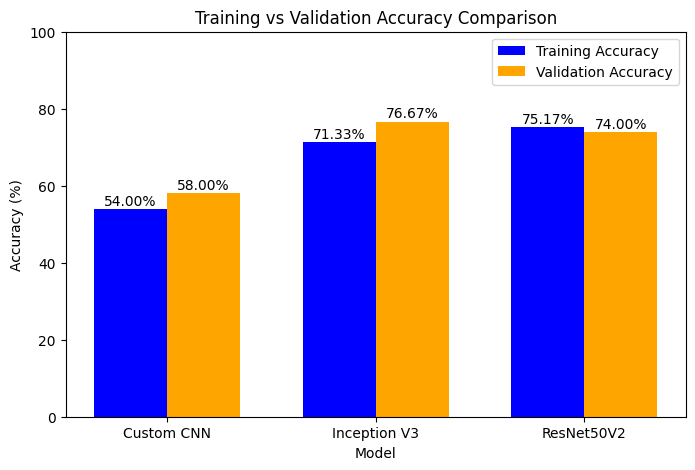

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Rename accuracy variables
accuracy_custom_cnn = custom_accuracy * 100  # Custom CNN Model Accuracy
accuracy_inception_v3 = test_accuracy * 100  # Inception V3 Model Accuracy
accuracy_resnet50v2 = accuracy * 100  # ResNet50V2 Model Accuracy

# Assuming validation accuracy is available
validation_accuracy_custom_cnn = max(history_custom.history['val_accuracy']) * 100
validation_accuracy_inception_v3 = max(history_transfer.history['val_accuracy']) * 100
validation_accuracy_resnet50v2 = max(history_resnet50v2.history['val_accuracy']) * 100

# Model names
model_names = ["Custom CNN", "Inception V3", "ResNet50V2"]

# Accuracy values
train_accuracies = [accuracy_custom_cnn, accuracy_inception_v3, accuracy_resnet50v2]
val_accuracies = [validation_accuracy_custom_cnn, validation_accuracy_inception_v3, validation_accuracy_resnet50v2]

# Bar Chart
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='blue')
rects2 = ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy', color='orange')

# Labels, Title, and Legend
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Training vs Validation Accuracy Comparison")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Display values on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height + 1, f'{height:.2f}%', ha='center', fontsize=10)

plt.ylim(0, 100)
plt.show()
